#                                        Исследование рака мозга

План исследования:

    0. Обработка данных

    1. Изучить процентные сотношения возраста, расы, пола, смертей, диагнозов заболевших, построить кривую выживаемости
    
    2. Выявить, мутации каких генов повышают риск возникновения рака
    
    3. Посмотреть, какое распредение будет у времени смерти с постановки дианоза
    
    4. Построить логистическую модель и научиться прогнозировать смерть больного человека

## Обработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [117]:
bcg = pd.read_csv('brain cancer gens.tsv', sep='\t')
clinical = pd.read_csv('clinical.tsv', sep='\t')
exposure = pd.read_csv('exposure.tsv', sep='\t')
family_history = pd.read_csv('family_history.tsv', sep='\t')
bcg.info()
clinical.info()
exposure.info()
family_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Symbol                               100 non-null    object
 1   Name                                 100 non-null    object
 2   # SSM Affected Cases in Cohort       100 non-null    object
 3   # SSM Affected Cases Across the GDC  100 non-null    object
 4   # CNV Gain                           100 non-null    object
 5   # CNV Loss                           100 non-null    object
 6   # Mutations                          100 non-null    int64 
 7   Annotations                          23 non-null     object
 8   Survival                             100 non-null    object
dtypes: int64(1), object(8)
memory usage: 7.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732 entries, 0 to 2731
Columns: 158 entries, case_id to treatment_type
dtypes: ob

Выделим основные проблемы нашего дата-сета:

   1. Много столбцов с пустыми или не нужными для исследования данными

   2. Столбец age_at_diagnosis указан в днях

   3. В столбце age_at_index отсуствуют данные у умерших

Пути решения:

1. Удаляем столбцы, где менее 5 заполненных ячеек

2. Переводим объекты типа object в тип int в столбце age_at_diagnosis. Делим значения столбца age_at_diagnosis на 365

3. Присваиваем пустым ячейкам новые значения age_at_diagnosis



In [3]:
def clean_tsv_file(df):
    columns_to_drop = []

    for col in df.columns:
        non_dash_count = df[col].apply(lambda x: x != "'--" and x != "Not Reported").sum()
        
        if non_dash_count < 6:
            columns_to_drop.append(col)

    df.drop(columns=columns_to_drop, inplace=True)

clean_tsv_file(bcg)
clean_tsv_file(clinical)
clean_tsv_file(exposure)
clean_tsv_file(family_history)
#clinical_data = clinical[clinical['treatment_or_therapy'] == 'yes']
cleaned_clinical_data = clinical[(clinical['vital_status'] == 'Alive') | (clinical['vital_status'] == 'Dead')].copy()

print(cleaned_clinical_data.shape)
print(exposure.shape)

print(cleaned_clinical_data['age_at_index'].head(20))

(2691, 43)
(1345, 13)
0      47
1      47
2      31
3      31
4      44
5      44
6      60
7      60
8      53
9      53
10    '--
11    '--
12     17
13     17
14     64
15     64
16     86
17     86
18     46
19     46
Name: age_at_index, dtype: object


In [4]:
print(cleaned_clinical_data['age_at_index'].dtype)
print(cleaned_clinical_data['age_at_diagnosis'].dtype)
#cleaned_clinical_data['age_at_diagnosis'] = cleaned_clinical_data['age_at_diagnosis'].astype(int)
cleaned_clinical_data['age_at_diagnosis'] = pd.to_numeric(cleaned_clinical_data['age_at_diagnosis'], errors='coerce')

cleaned_clinical_data['age_at_diagnosis'] = cleaned_clinical_data['age_at_diagnosis'].fillna(0)

cleaned_clinical_data['age_at_index'] = (cleaned_clinical_data['age_at_diagnosis'] / 365.5).astype(int)
print(cleaned_clinical_data['age_at_diagnosis'].dtype)
print(cleaned_clinical_data['age_at_index'].dtype)

print(cleaned_clinical_data['age_at_index'].head(20))

object
object
float64
int32
0     47
1     47
2     31
3     31
4     44
5     44
6     60
7     60
8     53
9     53
10    58
11    59
12    17
13    17
14    64
15    64
16    86
17    86
18    46
19    46
Name: age_at_index, dtype: int32


In [5]:
bcg.drop('Survival', axis = 1, inplace=True)
exposure.drop('exposure_type', axis = 1, inplace=True)
columns_to_drop = ['age_is_obfuscated', 'cause_of_death', 'ethnicity', 'days_to_birth', 'synchronous_malignancy', 'who_cns_grade']
cleaned_clinical_data = cleaned_clinical_data.drop(columns=columns_to_drop)
cleaned_clinical_data = cleaned_clinical_data[cleaned_clinical_data['race'] != 'not reported']
cleaned_clinical_data = cleaned_clinical_data[cleaned_clinical_data['vital_status'] != 'Not Reported']

In [6]:
print(cleaned_clinical_data['age_at_index'].head(20))

0     47
1     47
2     31
3     31
4     44
5     44
8     53
9     53
10    58
11    59
12    17
13    17
14    64
15    64
16    86
17    86
18    46
19    46
20    50
21    50
Name: age_at_index, dtype: int32


## Процентные соотношения

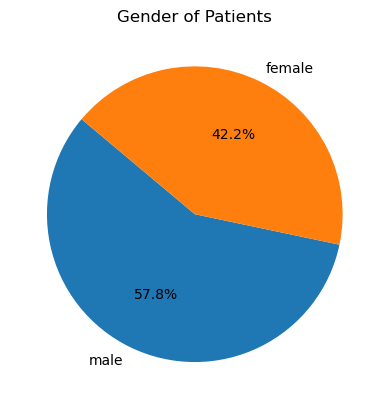

In [110]:
cleaned_clinical_data[['gender', 'race', 'vital_status', 'primary_diagnosis']].head()
gender_distribution = cleaned_clinical_data['gender'].value_counts(normalize=True) *100
gender_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Gender of Patients')
plt.ylabel('')
plt.xticks(rotation=0)
plt.show()

На диагремме видно, что больший процент заболевших - мужчины, однако сильного перевеса одного из полов нет. Следовательно, как мужчины, так и женщины находятся в группе риска.

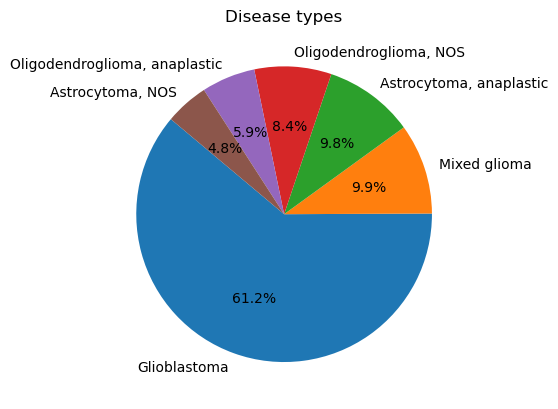

In [8]:
disease = cleaned_clinical_data['primary_diagnosis'].value_counts(normalize=True) * 100
disease=disease.head(6)

disease.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Disease types')
plt.ylabel(' ')
plt.xticks(rotation=0)
plt.show()

На диаграмме явно видно, что среди всех опухолей мозга наиболее часто встречается глиобластома.

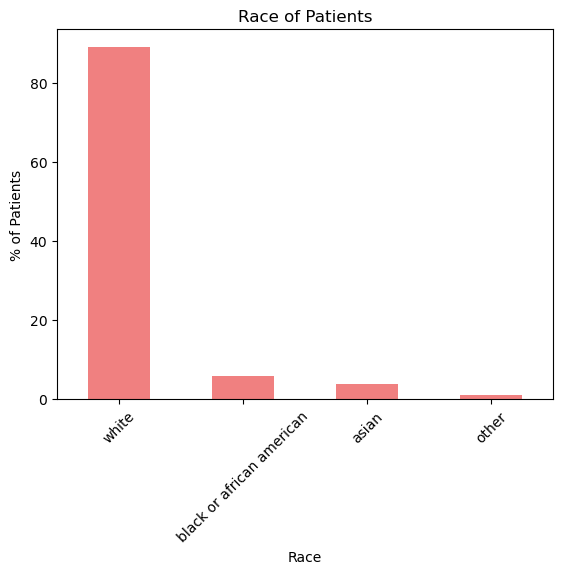

In [9]:
race_distribution = cleaned_clinical_data['race'].value_counts(normalize=True) * 100
top_4_races = race_distribution.head(4)

top_4_races.plot(kind='bar', color='lightcoral')
plt.title('Race of Patients')
plt.ylabel('% of Patients')
plt.xlabel('Race')
plt.xticks(rotation=45)
plt.show()

Исходя из результатов - в группе риска заболевания находятся белые люди, более 80% всех заболевших не являются темнокожими или азиатами. Однако, это также связано с тем, что темнокожих людей в целом меньше, а азиатов мало именно в месте исследования.

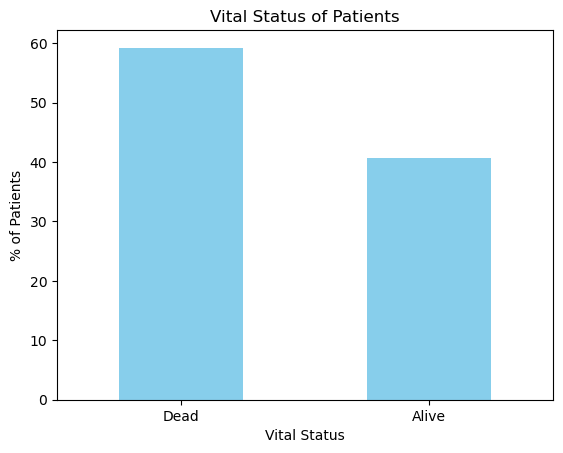

In [10]:
vital_status_distribution = cleaned_clinical_data['vital_status'].value_counts(normalize=True) * 100

vital_status_distribution.plot(kind='bar', color='skyblue')
plt.title('Vital Status of Patients')
plt.ylabel('% of Patients')
plt.xlabel('Vital Status')
plt.xticks(rotation=0)
plt.show()

Заметим, что процент смертей от рака мозга превышает выживаемость. Следовательно, рак мозга - очень агрессивный вид рака. 

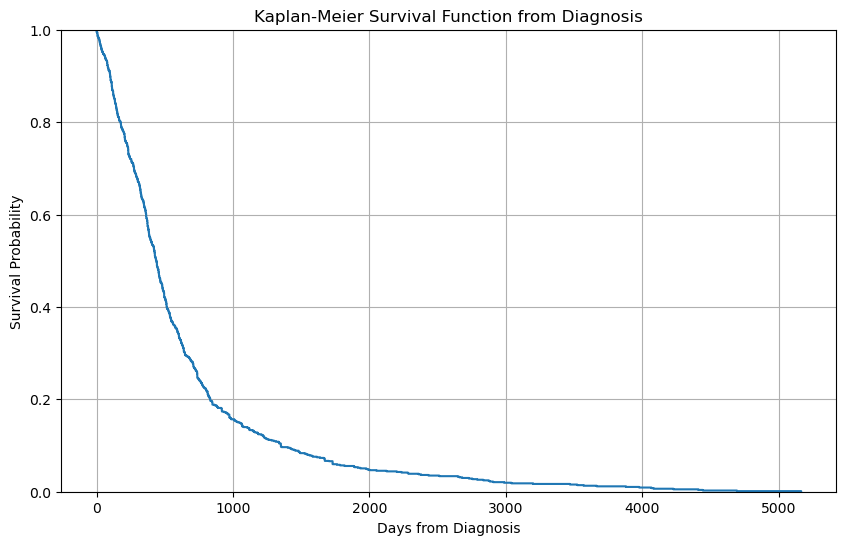

In [11]:
cleaned_clinical_data['days_to_death'] = pd.to_numeric(cleaned_clinical_data['days_to_death'], errors='coerce')

T = cleaned_clinical_data['days_to_death'].dropna()  
E = np.ones(len(T))  

sorted_indices = np.argsort(T)
sorted_T = T.iloc[sorted_indices]
sorted_E = E[sorted_indices]

unique_times = np.unique(sorted_T)
survival_probabilities = np.zeros(len(unique_times))
at_risk_count = len(sorted_T)

for i, time in enumerate(unique_times):
    event_count = np.sum(sorted_T == time)
    survival_prob = 1 - event_count / at_risk_count
    survival_probabilities[i] = survival_prob if i == 0 else survival_probabilities[i-1] * survival_prob
    at_risk_count -= event_count

plt.figure(figsize=(10, 6))
plt.step(unique_times, survival_probabilities, where='post')
plt.title('Kaplan-Meier Survival Function from Diagnosis')
plt.xlabel('Days from Diagnosis')
plt.ylabel('Survival Probability')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Мы применили метод Каплана-Мейера, который используется для оценки функций выживания из данных о времени жизни. В этом контексте он направлен на оценку вероятности выживания за определенные временные точки.
Видно, что уже через 3 года течения болезни шанс выживания меньше 20%. 

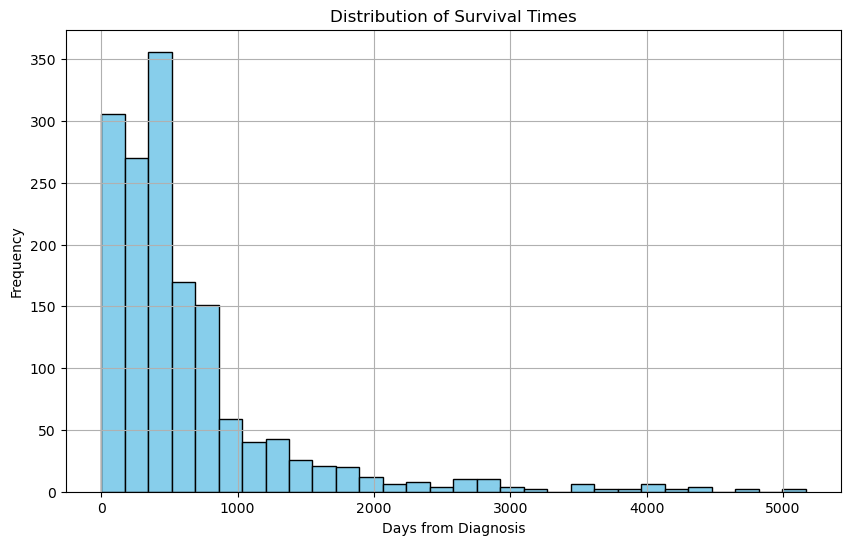

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(T, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Survival Times')
plt.xlabel('Days from Diagnosis')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

На этом графике показано, как распределяются данные из метода Каплана-Майера.

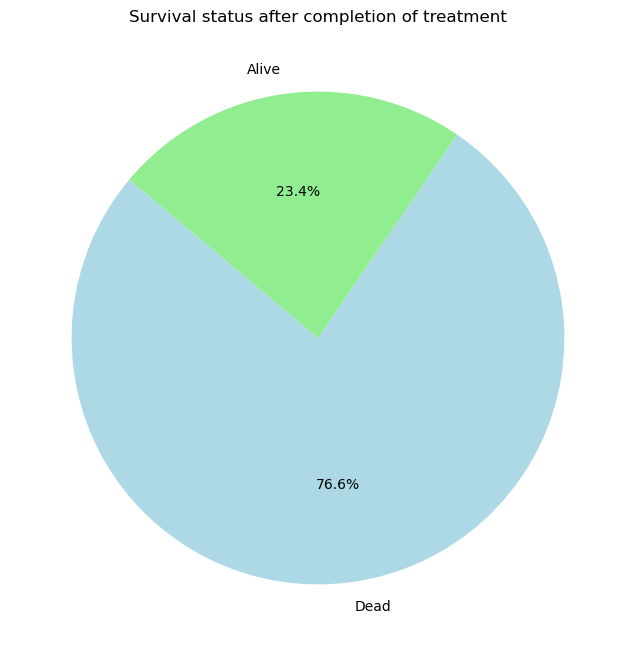

In [13]:
cleaned_clinical_data['days_to_treatment_end'] = pd.to_numeric(cleaned_clinical_data['days_to_treatment_end'], errors='coerce')

cleaned_clinical_data.dropna(subset=['days_to_treatment_end'], inplace=True)

status_counts = cleaned_clinical_data['vital_status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen'])
plt.title('Survival status after completion of treatment')
plt.show()

Заметим, что процент умерших после окончания лечения больше, чем в общем случае. Это значит, что после окончания лечения пациент не выздоравливает, а его переводят на паллиативную терапию, так как шанса выжить уже нет. 

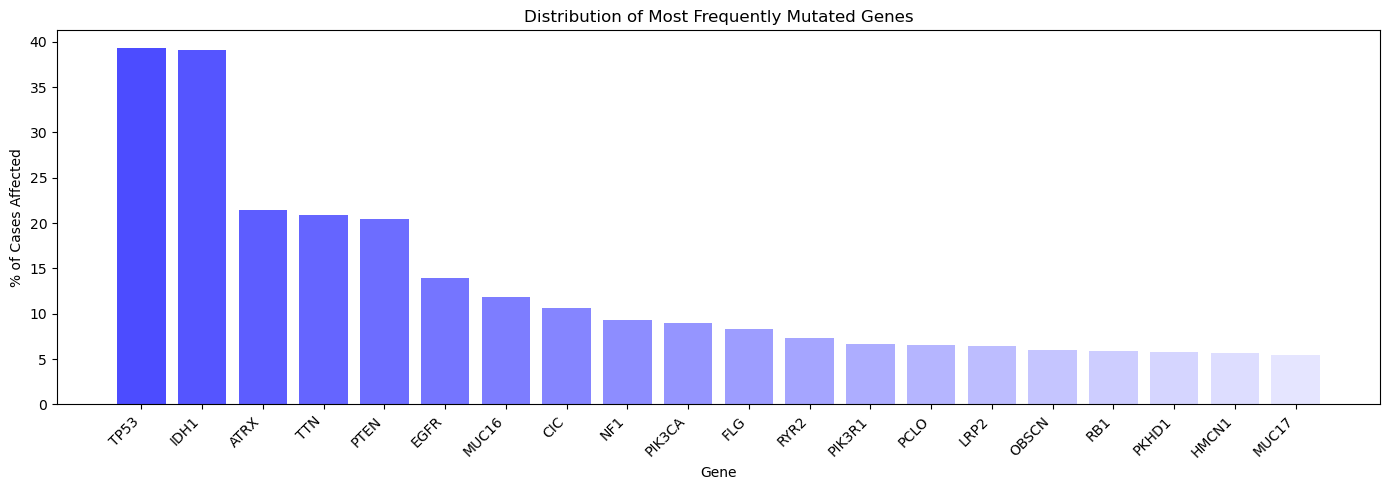

In [14]:
bcg['Percentage'] = bcg['# SSM Affected Cases in Cohort'].str.extract(r'(\d+\.\d+)%').astype(float)
top_20_bcg = bcg.head(20)
genes = top_20_bcg['Symbol']
percentages = top_20_bcg['Percentage']

plt.figure(figsize=(14, 5))
bars = plt.bar(genes, percentages, color='blue')

alphas = np.linspace(0.7, 0.1, len(bars))

for bar, alpha in zip(bars, alphas):
    bar.set_alpha(alpha)
plt.xlabel('Gene')  
plt.ylabel('% of Cases Affected')
plt.title('Distribution of Most Frequently Mutated Genes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Явно видно, что в геномах больных людей в примерно 40% случаев встречается мутация генов TP53 и IDH1.

Изучив информацию в интернете об этих генах, выяснилось, что первый из этих генов выполняет функцию супрессора образования зокачественых опухолей, то есть является антионкогеном. Мутации этого гена обнаруживаются в клетках около 50% раковых опухолей. 

Во втором из этих генов структурные изменения приводят к изменению его ферментативной активности, из-за чего в клтеках начинает накапливаться канцерогенный метаболит. Мутации этого гена обаружены в 70% случаев самых частых типов глиом (изображены на диаграмме Disease Types). 

Таким образом, мутации генов TP53 и IDH1 напрямую влияют на возникновение рака мозга. 

## Постороение распределения

Так как пункты исследования делались на разных ноутбуках, то пришлось для удобства и получения точных результатов перезагружать данные в каждом разделе.

In [23]:
bcg = pd.read_csv('brain cancer gens.tsv', sep='\t')
clinical = pd.read_csv('clinical.tsv', sep='\t')
exposure = pd.read_csv('exposure.tsv', sep='\t')
family_history = pd.read_csv('family_history.tsv', sep='\t')

In [24]:
clean_tsv_file(bcg)
clean_tsv_file(clinical)
clean_tsv_file(exposure)
clean_tsv_file(family_history)
cleaned_clinical_data = clinical[(clinical['vital_status'] == 'Alive') | (clinical['vital_status'] == 'Dead')]

Для исследования на распределение были выбраны следующие параметры: время до смерти с момента обнаружения модели и возраст на момент смерти.

In [37]:
clinical_with_death = cleaned_clinical_data[cleaned_clinical_data['year_of_death'] != "'--"]
clinical_unique = clinical_with_death.drop_duplicates(subset=['case_id'])
# Преобразование годов в числовой формат и вычисление возраста смерти
clinical_unique['year_of_birth'] = pd.to_numeric(clinical_unique['year_of_birth'])
clinical_unique['year_of_death'] = pd.to_numeric(clinical_unique['year_of_death'])
clinical_unique['age_of_death'] = clinical_unique['year_of_death'] - clinical_unique['year_of_birth']

age_of_death_array = clinical_unique['age_of_death'].dropna().values
time_to_death = []
for time in clinical_unique['days_to_death']:
    if time!="'--":
        if(int(time) > 35 and int(time) < 3000):
            time_to_death.append(int(time))

C:\Users\mirni\AppData\Local\Temp\ipykernel_80920\112837395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_unique['year_of_birth'] = pd.to_numeric(clinical_unique['year_of_birth'])
C:\Users\mirni\AppData\Local\Temp\ipykernel_80920\112837395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_unique['year_of_death'] = pd.to_numeric(clinical_unique['year_of_death'])
C:\Users\mirni\AppData\Local\Temp\ipykernel_80920\112837395.py:6: SettingWithCopyWarning: 
A value is trying to be set on 

Здесь для дальнейших результатов выбросы были отрезаны у массива time_to_death

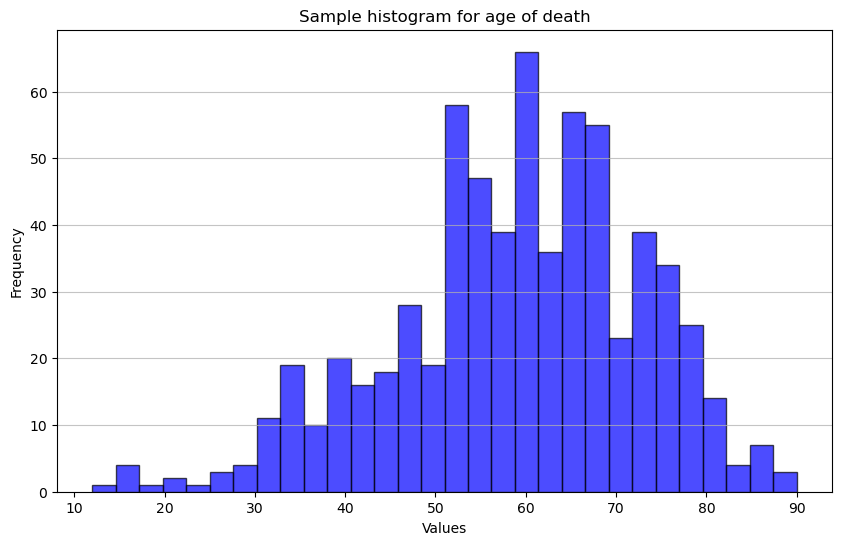

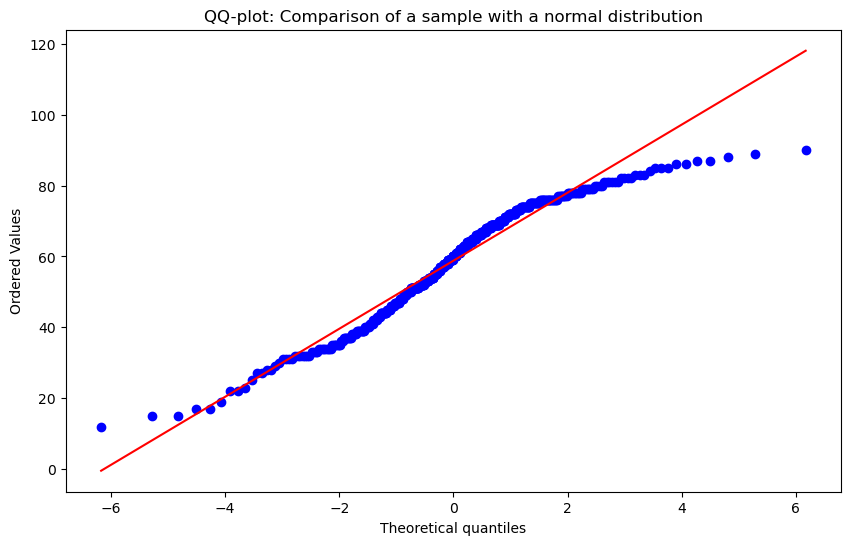

In [114]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy. stats import norm
plt.figure(figsize=(10, 6))
plt.hist(age_of_death_array, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Sample histogram for age of death')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Построение QQ-plot для сравнения с нормальным распределением
plt.figure(figsize=(10, 6))
stats.probplot(age_of_death_array, dist="laplace", plot=plt)
plt.title('QQ-plot: Comparison of a sample with a normal distribution')

plt.show()

По гистограмме возраста на момент смерти виден довольно тяжелый хвост слева и большие проседания в центре, что очень портит схожесть с нормальным распределением. Также на QQ-Plot заметны различия с нормальным распределением, плюс с такими траекториями довольно трудно угадать, какое распределение имеет наша выборка. Поэтому попытаемся приблизительно оценить, какое распределение имеет время с момента обнаружеения болезни до смерти

In [47]:
time_to_death_log = np.log(time_to_death)


Здесь сразу же создается прологарифмированный массив, он пригодится в дальнейшем

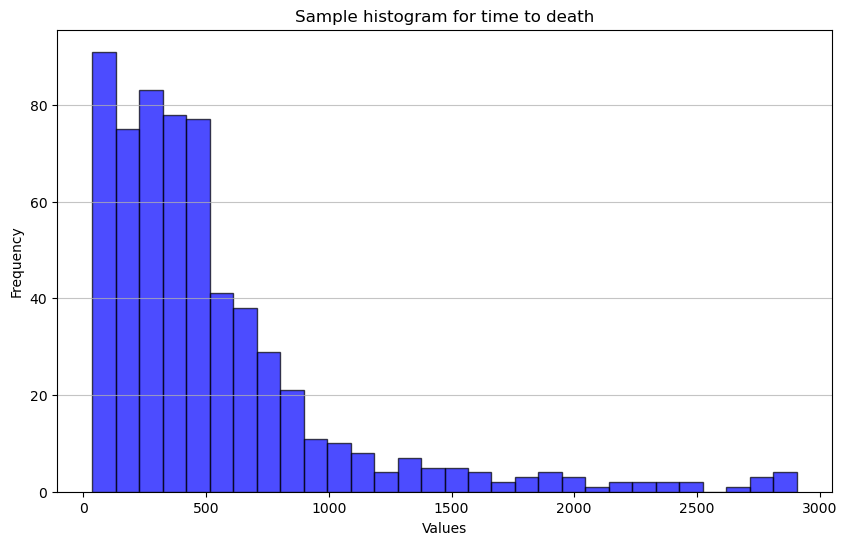

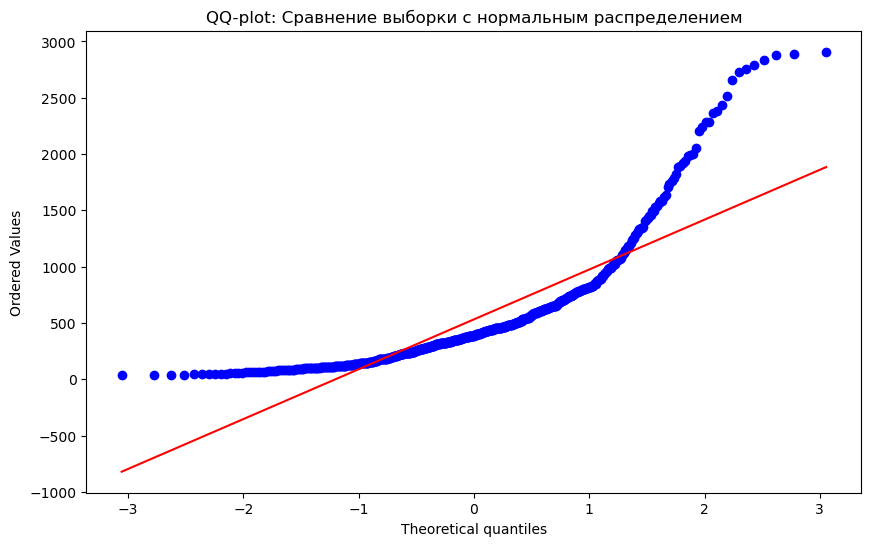

In [55]:
import matplotlib.pyplot as plt
from scipy. stats import norm
plt.figure(figsize=(10, 6))
plt.hist(time_to_death, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Sample histogram for time to death')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Построение QQ-plot для сравнения с нормальным распределением
plt.figure(figsize=(10, 6))
stats.probplot(time_to_death, dist="norm", plot=plt)
plt.title('QQ-plot: Comparison of a sample with a normal distribution')

plt.show()

Вид QQ-Plot напоминает логнормальное распределение, так как квантили в начале и конце больше, чем у нормального, а в центре идет приближение.

In [51]:
statistic, p_value = stats.shapiro(time_to_death_log)
print(p_value)

0.0018489921931177378


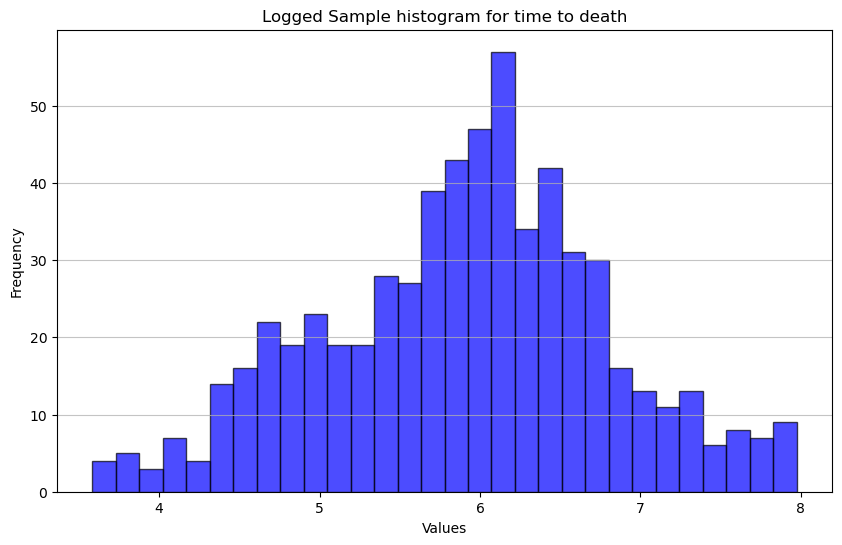

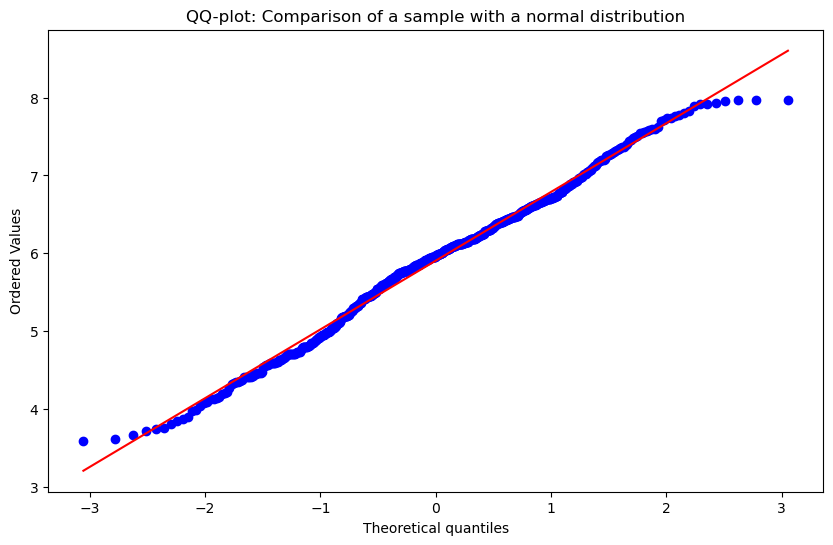

In [56]:
import matplotlib.pyplot as plt
from scipy. stats import norm
plt.figure(figsize=(10, 6))
plt.hist(time_to_death_log, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Logged Sample histogram for time to death')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Построение QQ-plot для сравнения с нормальным распределением
plt.figure(figsize=(10, 6))
stats.probplot(time_to_death_log, dist="norm", plot=plt)
plt.title('QQ-plot: Comparison of a sample with a normal distribution')

plt.show()

Хоть гипотеза и провалила тест Шапиро-Уилка, все же видна схожесть распределения выборки с логнормальным распределением: на QQ-Plot квантили выборки довольно близко лежат к красной линии, что означает схожесть распределения прологарифмированной выборки с нормальным распределением

## Построение логистической модели классификации

Мы будем предсказывать умер ли заболевший на момент фиксации данных в таблице.
Выбор пал на логистическую регрессию в связи со следующими причинами:

    1) Хорошо подходит для предсказания бинарных данных
    2) Часто используется в медицинских исследованиях
    3) В отличие от Knn приспособлена для большого количества параметров

In [81]:
bcg = pd.read_csv('brain cancer gens.tsv', sep='\t')
clinical = pd.read_csv('clinical.tsv', sep='\t')
exposure = pd.read_csv('exposure.tsv', sep='\t')
family_history = pd.read_csv('family_history.tsv', sep='\t')

In [82]:
clean_tsv_file(bcg)
clean_tsv_file(clinical)
clean_tsv_file(exposure)
clean_tsv_file(family_history)
cleaned_clinical_data = clinical[(clinical['vital_status'] == 'Alive') | (clinical['vital_status'] == 'Dead')].copy()


In [83]:
cleaned_clinical_data['age_at_diagnosis'] = pd.to_numeric(cleaned_clinical_data['age_at_diagnosis'], errors='coerce')
cleaned_clinical_data['age_at_diagnosis'] = cleaned_clinical_data['age_at_diagnosis'].fillna(0)
cleaned_clinical_data['age_at_index'] = (cleaned_clinical_data['age_at_diagnosis'] / 365.5).astype(int)
cleaned_clinical_data = cleaned_clinical_data[cleaned_clinical_data['age_at_index'] > 0]

In [84]:
exposure.drop('exposure_type', axis = 1, inplace=True)
columns_to_drop = ['age_is_obfuscated', 'cause_of_death', 'ethnicity', 'days_to_birth', 'synchronous_malignancy', 'who_cns_grade', 'age_at_diagnosis']
cleaned_clinical_data = cleaned_clinical_data.drop(columns=columns_to_drop)
cleaned_clinical_data = cleaned_clinical_data[cleaned_clinical_data['race'] != 'not reported']
cleaned_clinical_data = cleaned_clinical_data[cleaned_clinical_data['vital_status'] != 'Not Reported']

In [104]:
from sklearn.model_selection import train_test_split

merged_data = pd.merge(cleaned_clinical_data, exposure, on='case_id', how='left')
merged_unique = merged_data.drop_duplicates(subset=['case_id'])

X = merged_unique.drop(['vital_status', 'days_to_death', 'year_of_death', ], axis=1)
y = merged_unique['vital_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
y_train = y_train.map({'Alive': 0, 'Dead': 1})
y_test = y_test.map({'Alive': 0, 'Dead': 1})
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(merged_unique.shape)

X_train shape: (1100, 44)
y_train shape: (1100,)
X_test shape: (195, 44)
y_test shape: (195,)
(1295, 47)


In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns.drop('case_id')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index([], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['case_s...
       'treatment_or_therapy', 'treatment_outcome', 'treatment_type',
       'case_submitter_id_y', 'project_id_y', 'alcohol_history',
       'alcohol_intensity', 'cigarettes_per_day', 'exposure_duration_years',
       'pack_years_smoked', 'tobacco_smoking_onset_year',
       'tobacco_smoking_quit_year', 'tobacco_smoking_status', 'years_smoked'],
      dtype='object'))])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Трансформер в `scikit-learn` — это объект, который реализует методы `fit()` и `transform()`, а иногда и `fit_transform()`. Он предназначен для выполнения определённых преобразований над данными. Например, трансформер может масштабировать числовые данные, кодировать категориальные данные в числовые, заполнять пропущенные значения или выбирать определённые признаки из данных.

Метод `fit()` "обучается" на данных, определяя параметры преобразования (например, минимум и максимум для масштабирования).
Метод `transform()` применяет преобразование к данным, используя параметры, определённые во время вызова `fit()`.
Метод `fit_transform()` выполняет оба этих шага одновременно, что может быть более эффективным.

Пайплайн в `scikit-learn` представляет собой последовательность шагов обработки данных, которые могут включать один или несколько трансформеров и, как правило, завершаются моделью машинного обучения (которая также называется оценщиком). Каждый шаг в пайплайне является кортежем, состоящим из имени и объекта (трансформера или модели). Пайплайн реализует методы `fit()`, `transform()`, и `predict()`, позволяя применять сложную последовательность преобразований и моделирования в едином процессе.

Метод `fit()` пайплайна обучает все трансформеры и модель, последовательно применяя метод `fit()` и, если требуется, `transform()` к данным на каждом шаге.
Метод `transform()` применяется только если все шаги в пайплайне (кроме последнего) являются трансформерами. Он пропускает данные через все трансформеры в пайплайне.
Метод `predict()` используется для генерации предсказаний с помощью окончательной модели, после применения всех преобразований к данным.

`StandardScaler` является трансформером, который масштабирует признаки, удаляя среднее значение и масштабируя их к единичной дисперсии. Это обычная практика предобработки данных для многих алгоритмов машинного обучения, поскольку она делает модель менее чувствительной к масштабу признаков.

In [125]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score


y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {precision}")
print(f"Accuracy: {recall}")
print(f"F1-score: {f1_score}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.88
Accuracy: 0.9322033898305084
F1-score: 0.905349794238683
Accuracy: 0.882051282051282
ROC AUC: 0.9249394673123488


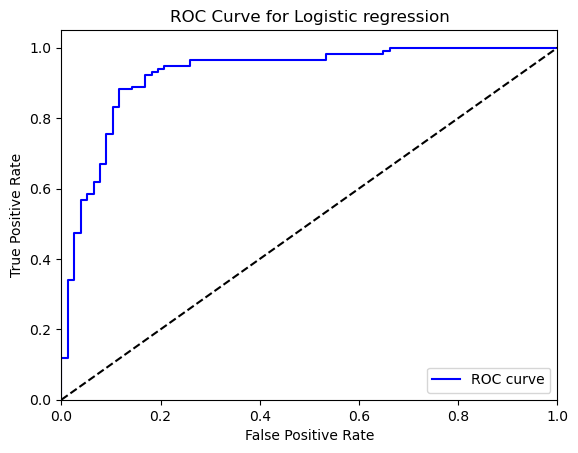

In [107]:
from sklearn.metrics import roc_curve, auc
y_prob = model.predict_proba(X_test)
plt.figure()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='b', label='ROC curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic regression')
plt.legend(loc="lower right")
plt.show()

# Выводы

В процессе реализации проекта мы подобно изучили рак мозга. Были обработаны не только клинические данные, но и данные о мутациях генов.

Поиск распределения привел нас к выводу, что в клиническиих исследованиях, а в особенности раковых заболеваниях, конкретное распределение какого-либо признака построить тяжело, так как болезнь непредсказуема. Разумеется, чем старше человек, тем выше шанс умереть из-за сопутсвующих заболеваний.

С помощью логистической модели мы научились прогнозировать смерть больного человека с точностью 88%, что является очень хорошим результатом.

Выявленные закономерности помогают врачам в лечении больных, прогнозировании течения заболевания и, возможно, создании "вакцины" от рака.